In [1]:
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

# I. SQL

Имеются данные по времени совершения сетевых действий (cчитаем, что записей миллиарды)

ID - идентификатор абонента
BS - номер базовой станции (вышки)
time - время совершения разового действия (отправка смс)

Необходимо построить таблицу вида

ID	BS	time_start	time_end

, где по каждому абоненту будет приведено время начала его присутствия на БС и время окончания			

Условно считаем, что время начала совпадает со временем первого действия на этой БС, 			
а время окончания - со временем первого действия на следующей БС, либо, если ее нет, со временем последнего действия на этой БС

In [2]:
import sqlite3
import pandas as pd

In [3]:
# Путь к тестовой БД sqlite3 с предварительно сгенерированными
# случайными данными согласно образцу в задании:

db_file = '../resources/mts_test.db'

In [4]:
def create_connection(db_file):
    """Создает полключение к базе данных sqlite3"""
    try:
        conn = \
            sqlite3.connect(db_file,
                            detect_types=sqlite3.PARSE_DECLTYPES |
                            sqlite3.PARSE_COLNAMES)
        return conn
    except Error as e:
        print(e)

    return None

In [5]:
# Проверяем соединение:

create_connection(db_file)

In [6]:
def bs_user_action_selection(db_file, limit=1000):
    conn = create_connection(db_file, )
    cursor = conn.cursor()
    sql = \
        '''SELECT * FROM bs_user_action LIMIT {}'''.format(limit)
    query = cursor.execute(sql)
    cols = [column[0] for column in query.description]
    result = pd.DataFrame(query.fetchall(), columns=cols)
    return result

In [136]:
# Исходная таблица с предварительно сгенерированными случайными данными (https://www.mockaroo.com/):
bs_user_action_selection(db_file)

,ID,BS,time
0,1009,5,10:22:18
1,1009,3,06:21:51
2,1010,2,17:06:36
3,1009,3,20:43:09
4,1004,4,03:48:42
...,...,...,...
995,1009,2,07:12:03
996,1008,2,03:22:07
997,1002,5,20:44:01
998,1002,5,19:33:29


In [154]:
# Создадим индекс на ID и time - для более оптимального и упорядоченного хранения пар ID и time

conn = create_connection(db_file, )
cursor = conn.cursor()
sql = '''
    CREATE INDEX IF NOT EXISTS ID_time ON bs_user_action (ID, time);
'''
cursor.execute(sql)
conn.close()

In [157]:
def result_table(db_file,):
    conn = create_connection(db_file, )
    cursor = conn.cursor()
    sql = \
        '''
        WITH action_numbers AS (
        SELECT
            ID,
            BS,
            time,
            -- Проставляем каждому действию конкретного абонента порядковый номер:
            row_number() OVER (PARTITION BY ID ORDER BY time ASC) AS action_number 
        FROM bs_user_action
        ORDER BY ID, time
        ),
        joins AS (
        SELECT
            an_first.ID, 
            an_first.BS AS current_BS, an_first.time AS time_start, an_first.action_number AS current_action,
            an_second.BS AS end_BS, an_second.time AS time_end, an_second.action_number AS next_action
        FROM action_numbers AS an_first
        -- Делаем левое соединение таблиц с пользовательскими действиями
        -- (чтобы не потерять случаи с последним пользовательским действием) 
        -- по ID абонента и его следующему действию. 
        LEFT JOIN action_numbers AS an_second ON an_first.ID = an_second.ID 
            AND an_first.action_number = an_second.action_number - 1
        ORDER BY an_first.time)
        -- Таблица с результатами:
        SELECT
            ID,
            current_BS AS BS,
            time_start,
            -- Не забываем включить условие, что если отсутствует следующее действие aбонента на следующей БС,
            -- то в качестве end_time проставляем время действия на текущей БС:
            CASE WHEN end_BS IS NULL THEN time_start ELSE time_end END AS time_end
        FROM joins
        ORDER BY time_start, ID;
        '''
    query = cursor.execute(sql)
    cols = [column[0] for column in query.description]
    result = pd.DataFrame(query.fetchall(), columns=cols)
    return result

In [158]:
%%timeit
result_table(db_file)

10.9 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
df = result_table(db_file)

In [14]:
# Проверим результат на одном из абонентов:
df[df.ID == 1010]

,ID,BS,time_start,time_end
16,1010,5,00:33:24,00:38:31
20,1010,1,00:38:31,00:46:42
28,1010,5,00:46:42,01:07:15
41,1010,1,01:07:15,01:30:55
55,1010,5,01:30:55,01:41:28
...,...,...,...,...
977,1010,3,23:14:33,23:23:30
983,1010,4,23:23:30,23:32:14
988,1010,3,23:32:14,23:56:40
998,1010,4,23:56:40,23:57:49


# II. Python

1. Есть два списка чисел: цены товаров в одном салоне и цены товаров в другом салоне.
Нужно сравнить средние цены, минимальные цены и максимальные в салонах. Если первое зачение меньше надо вернуть 'First', если второе, то 'Second', а если равны, то 'Equal'
Например, для func_name([1, 2, 3], [2, 2, 2]) должно вернуться ('Equal', 'First', 'Second')
, где 1 - средняя цена в первом салоне, 2 - минимальная цена в первом салоне, 3 - максимальная цена в первом салоне; во втором салоне все цены равны 2

(доп. усложение: код следует написать после слова "return", а не между определением функции и "return", как обычно)

In [57]:
def mean_min_max_compare(x, y):
    """
    Маппирует лямбда функцию сравнения попарно к двум спискам, возвращает ответ в виде кортежа.
    """
    return tuple(map(lambda x, y: 'First' if x < y else 'Second' if x > y else 'Equal', x, y))

In [58]:
mean_min_max_compare([1, 2, 3], [2, 2, 2])

('First', 'Equal', 'Second')

2. Напишите функцию, которая по множеству, возвращает список всех его подмножеств
проверяться будет на данных вида set(range(10)), более сложные/составные типы данных можно не учитывать

In [64]:
from itertools import chain, combinations

def powerset(x):
    """
    Подмножества (вкл. пустое множество) с помощью инструментов стандартной библиотеки itertools:
    combinations (кобинации без повторений) и chain.from_iterable - "сцепка" элементов итерируемых объектов.
    """
    s = list(x)
    return chain.from_iterable(combinations(s, r) for r in range(len(x)+1))

In [100]:
list(powerset(set(range(3))))

[(), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)]

In [103]:
list(powerset({'A', 'B', 'C', 'D'}))

[(),
 ('B',),
 ('C',),
 ('A',),
 ('D',),
 ('B', 'C'),
 ('B', 'A'),
 ('B', 'D'),
 ('C', 'A'),
 ('C', 'D'),
 ('A', 'D'),
 ('B', 'C', 'A'),
 ('B', 'C', 'D'),
 ('B', 'A', 'D'),
 ('C', 'A', 'D'),
 ('B', 'C', 'A', 'D')]

3. Загрузите набор данных "Breast Cancer Wisconsin (Diagnostic) Database" 
(с помощью библиотеки sklearn; метод load_breast_cancer())

Каково соотношение классов?
Насколько сильно различаются между собой объекты классов Malignan и Benign по паре признаков 'mean radius' и 'mean texture', а также по паре признаков 'mean perimeter' и 'mean area'?
(необходимо изобразить графически)

Какие фичи в наборе данных можно считать наиболее важными для машинного разделения на классы Malignan и Benign? Какими можно пренебречь?

In [84]:
from sklearn.datasets import load_breast_cancer
import numpy as np

In [93]:
# Преобразуем датасет в pandas dataframe:

cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns= np.append(cancer['feature_names'], ['target']))

In [101]:
df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0


In [99]:
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [166]:
df['target_names'] = df['target'].apply(lambda x: 'malignant' if x == 0 else 'benign')

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='mean radius', ylabel='mean texture'>

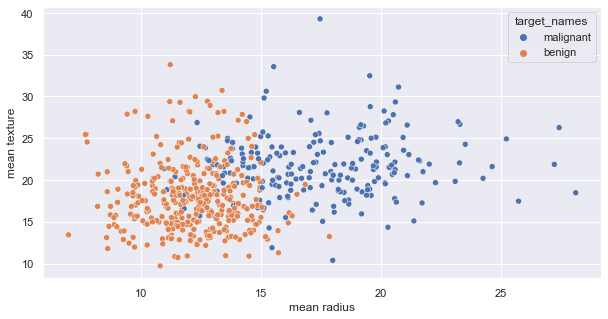

In [186]:
plt.figure(figsize = (10,5))
sns.scatterplot(data=df, x="mean radius", y="mean texture", hue="target_names")

<AxesSubplot:xlabel='mean perimeter', ylabel='mean area'>

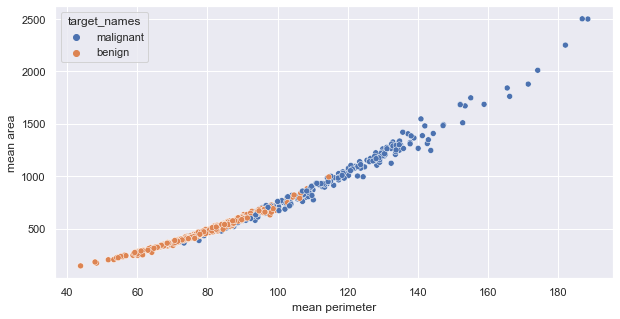

In [187]:
plt.figure(figsize = (10,5))
sns.scatterplot(data=df, x="mean perimeter", y="mean area", hue="target_names")

<AxesSubplot:>

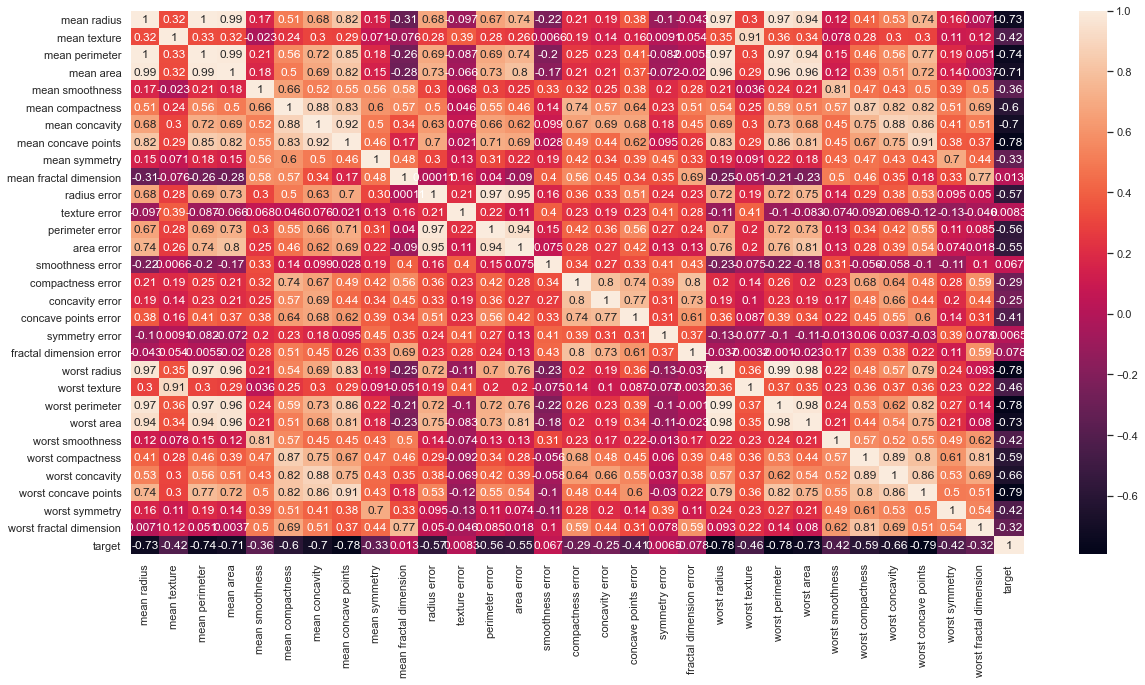

In [188]:
corrMatrix = df.corr()
plt.figure(figsize = (20,10))
sns.heatmap(corrMatrix, annot=True)